# 파이토치를 활용한 회귀모델

> California Housing EDA and Modeling

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

In [4]:
import torch
import torch.nn as nn #은닉층같은것을 다른사람이 만들어 놓은것을 불러오는것
import torch.optim as optim #최적화함수
from torch.utils.data import Dataset, DataLoader, TensorDataset #입력층 

#PyTorch 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [6]:
from pathlib import Path
DATA_PATH = Path("data/housing.csv")
df = pd.read_csv(DATA_PATH)
# print(df.describe())
# print(df.isnull().sum())

In [7]:
corr = df.corr(numeric_only=True)
target_corr = corr["median_house_value"].sort_values(ascending=False)
# print("타겟과의 상관관계:")
# print(target_corr)

In [8]:
# %%
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

num_features = X.select_dtypes(include=["float64", "int64", "float32", "int32"]).columns.tolist()
cat_features = ["ocean_proximity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# 기본 전처리 (파이프라인 없이)
print("데이터 전처리 중...")

# 숫자형 피처 전처리
imputer = SimpleImputer(strategy="median")
X_train_num = imputer.fit_transform(X_train[num_features])
X_test_num = imputer.transform(X_test[num_features])

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# 범주형 피처 전처리
encoder = OneHotEncoder()
X_train_cat = encoder.fit_transform(X_train[cat_features]).toarray()
X_test_cat = encoder.transform(X_test[cat_features]).toarray()

# 전처리된 데이터 결합
X_train_processed = np.hstack([X_train_num_scaled, X_train_cat])
X_test_processed = np.hstack([X_test_num_scaled, X_test_cat])

print(f"전처리된 훈련 데이터 형태: {X_train_processed.shape}")
print(f"전처리된 테스트 데이터 형태: {X_test_processed.shape}")

# 타겟값도 스케일링을 추가(매우 중요합니다!)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1)).flatten()
y_test_scaled = y_scaler.fit_transform(y_test.values.reshape(-1,1)).flatten()

# Numpy -> Tensor로 변경해야 됨. (지도학습)
X_train_tensor = torch.FloatTensor(X_train_processed)
X_test_tensor = torch.FloatTensor(X_test_processed)
y_train_tensor = torch.FloatTensor(y_train_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

print(f"X_train_tensor 형태: {X_train_tensor.shape}")
print(f"X_test_tensor 형태: {X_test_tensor.shape}")
print(f"y_train_tensor 형태: {y_train_tensor.shape}")
print(f"y_test_tensor 형태: {y_test_tensor.shape}")


데이터 전처리 중...
전처리된 훈련 데이터 형태: (16512, 13)
전처리된 테스트 데이터 형태: (4128, 13)
X_train_tensor 형태: torch.Size([16512, 13])
X_test_tensor 형태: torch.Size([4128, 13])
y_train_tensor 형태: torch.Size([16512])
y_test_tensor 형태: torch.Size([4128])


In [12]:
#PyTorch 모델을 정의해봅시다. (생성자와 순방향은 내가 만들어야한다. 역방향은 안만든다)
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim): #생성자를 만들때 도대체 어떤 인수가 필요한가요?
        super().__init__()
        self.liner = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.liner(X)

딥러닝 트레인 필수 코스 
책의 내용은 여기저기 흩어져있다. 이렇게 작성된것을 잘기억해야한다.
loss 값 구해야한다. 

In [21]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=1000, lr=0.001, patience=50):
    #활성화 함수
    #손실함수
    #최적화함수
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    #optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        #1. 학습 
        model.train()
        #2. 초기화 (기존꺼 버리고 0으로 초기화)
        optimizer.zero_grad()

        train_pred = model(X_train)
        train_loss = criterion(train_pred, y_train)
        #loss로부터 역전파
        train_loss.backward()
        optimizer.step() #모델이 수정된것 
#검증해야함. 필요 1. 기울기를 움직이지 않도록 고정시켜야함.
        model.eval() #모델에 있는거 손대지마, 검증모델을 만들어 
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"train_losses: {train_losses}")
        print(f"val_losses: {val_losses}")

In [20]:
lr = LinearRegressionModel(X_test_tensor.shape[1])
#train_model(lr, X_test_tensor, y_test_tensor, )
n_train = int(0.8*len(X_test_tensor))
indices = torch.randperm(len(X_train_tensor))
train_indices = indices[:n_train]
val_indices = indices[n_train:]

X_sub_train = X_train_tensor[train_indices]
y_sub_train = y_train_tensor[train_indices]
X_sub_val = X_train_tensor[val_indices]
y_sub_val = y_train_tensor[val_indices]


In [22]:
train_model(lr, X_sub_train, y_sub_train, X_sub_val, y_sub_val)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not DataFrame

검증해야함.
 필요 1. 기울기를 움직이지 않도록 고정시켜야함.

In [10]:
print("=" * 60)
print("1단계: 기본 모델들의 교차 검증 성능 비교")
print("=" * 60)

# 기본 모델들 평가
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42, max_iter=5000),
    'Lasso Regression': Lasso(random_state=42, max_iter=5000),
    'Random Forest': RandomForestRegressor(random_state=42)
}

cv_results = []
for name, model in models.items():
    result = evaluate_model_cv(name, model, X_train_processed, y_train)
    cv_results.append(result)

1단계: 기본 모델들의 교차 검증 성능 비교

Linear Regression - 교차 검증 결과:
-- RMSE: 68604.16 (+/- 2649.89)
-- R^2: 0.6477 (+/- 0.0264)

Ridge Regression - 교차 검증 결과:
-- RMSE: 68595.60 (+/- 2632.15)
-- R^2: 0.6478 (+/- 0.0265)

Lasso Regression - 교차 검증 결과:
-- RMSE: 68603.23 (+/- 2647.51)
-- R^2: 0.6477 (+/- 0.0264)

Random Forest - 교차 검증 결과:
-- RMSE: 49424.12 (+/- 2463.17)
-- R^2: 0.8172 (+/- 0.0110)


In [11]:
print("\n" + "=" * 60)
print("2단계: 그리드 탐색을 통한 하이퍼파라미터 최적화")
print("=" * 60)

# Random Forest 그리드 탐색
print("Random Forest 그리드 탐색 중... (시간이 다소 소요됩니다)")
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
rf_grid.fit(X_train_processed, y_train)
print(f"Random Forest Grid - 최적 파라미터: {rf_grid.best_params_}")
print(f"Random Forest Grid - 최적 RMSE: {np.sqrt(-rf_grid.best_score_):.2f}")


2단계: 그리드 탐색을 통한 하이퍼파라미터 최적화
Random Forest 그리드 탐색 중... (시간이 다소 소요됩니다)
Random Forest Grid - 최적 파라미터: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Grid - 최적 RMSE: 49273.74


In [12]:
print("\n" + "=" * 60)
print("2-2단계: 랜덤 그리드 탐색을 통한 하이퍼파라미터 최적화")
print("=" * 60)

from scipy.stats import uniform, randint

# Random Forest 랜덤 그리드 탐색
print("Random Forest 랜덤 탐색 중...")
rf_param_dist = {
    'n_estimators': randint(50, 300),        # 50~299 사이의 정수
    'max_depth': [5, 10, 15, 20, None],      # 이산 값
    'min_samples_split': randint(2, 20),     # 2~19 사이의 정수
    'min_samples_leaf': randint(1, 10),      # 1~9 사이의 정수
    'max_features': ['sqrt', 'log2', None]   # 특성 선택 방법
}
rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_dist,
    n_iter=100,  # 100개의 랜덤 조합 시도
    cv=cv,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
rf_random.fit(X_train_processed, y_train)
print(f"Random Forest Random - 최적 파라미터: {rf_random.best_params_}")
print(f"Random Forest Random - 최적 RMSE: {np.sqrt(-rf_random.best_score_):.2f}")

print("그리드 탐색 vs 랜덤 탐색 비교")
print("Random Forest:")
print(f"  Grid Search RMSE: {np.sqrt(-rf_grid.best_score_):.2f}")
print(f"  Random Search RMSE: {np.sqrt(-rf_random.best_score_):.2f}")


2-2단계: 랜덤 그리드 탐색을 통한 하이퍼파라미터 최적화
Random Forest 랜덤 탐색 중...
Random Forest Random - 최적 파라미터: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 165}
Random Forest Random - 최적 RMSE: 49359.13
그리드 탐색 vs 랜덤 탐색 비교
Random Forest:
  Grid Search RMSE: 49273.74
  Random Search RMSE: 49359.13


In [13]:
print("\n" + "=" * 60)
print("3단계: 다항식 특성을 포함한 고급 모델")
print("=" * 60)

# 다항식 특성 생성
print("다항식 특성 생성 중...")
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_train_num_poly = poly.fit_transform(X_train_num_scaled)
X_test_num_poly = poly.transform(X_test_num_scaled)

# 다항식 특성과 범주형 특성 결합
X_train_poly_combined = np.hstack([X_train_num_poly, X_train_cat])
X_test_poly_combined = np.hstack([X_test_num_poly, X_test_cat])

print(f"다항식 특성 포함 훈련 데이터 형태: {X_train_poly_combined.shape}")

# 다항식 Ridge 그리드 탐색
print("다항식 Ridge 회귀 최적화 중...")
poly_param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
poly_ridge_grid = GridSearchCV(
    Ridge(random_state=42),
    poly_param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
poly_ridge_grid.fit(X_train_poly_combined, y_train)
print(f"Polynomial Ridge - 최적 파라미터: {poly_ridge_grid.best_params_}")
print(f"Polynomial Ridge - 최적 RMSE: {np.sqrt(-poly_ridge_grid.best_score_):.2f}")


3단계: 다항식 특성을 포함한 고급 모델
다항식 특성 생성 중...
다항식 특성 포함 훈련 데이터 형태: (16512, 49)
다항식 Ridge 회귀 최적화 중...
Polynomial Ridge - 최적 파라미터: {'alpha': 100.0}
Polynomial Ridge - 최적 RMSE: 68948.37


In [14]:
print("\n" + "=" * 60)
print("4단계: 테스트 세트에서 최종 성능 평가")
print("=" * 60)

# 최적화된 모델들을 테스트 세트에서 평가 (그리드 탐색과 랜덤 탐색 결과 모두 포함)
optimized_models = {
    'Random Forest (Grid)': (rf_grid.best_estimator_, X_test_processed),
    'Random Forest (Random)': (rf_random.best_estimator_, X_test_processed),
    'Polynomial Ridge (Grid)': (poly_ridge_grid.best_estimator_, X_test_poly_combined)
}

final_results = []
predictions_dict = {}

for name, (model, X_test_data) in optimized_models.items():
    # 테스트 예측
    y_pred = model.predict(X_test_data)
    predictions_dict[name] = y_pred
    
    # 성능 계산
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\n{name}:")
    print(f"-- Test R^2: {r2:.4f}")
    print(f"-- Test RMSE: {rmse:.2f}")
    
    final_results.append({
        'model': name,
        'test_r2': r2,
        'test_rmse': rmse
    })


4단계: 테스트 세트에서 최종 성능 평가

Random Forest (Grid):
-- Test R^2: 0.8184
-- Test RMSE: 48781.91

Random Forest (Random):
-- Test R^2: 0.8168
-- Test RMSE: 48993.53

Polynomial Ridge (Grid):
-- Test R^2: 0.6714
-- Test RMSE: 65621.28



5단계: 특성 중요도 분석 (Random Forest)
상위 10개 중요한 특성:
                       feature  importance
7                median_income    0.490384
9       ocean_proximity_INLAND    0.141366
0                    longitude    0.105698
1                     latitude    0.101170
2           housing_median_age    0.052319
5                   population    0.032625
3                  total_rooms    0.023652
4               total_bedrooms    0.023641
6                   households    0.018241
12  ocean_proximity_NEAR OCEAN    0.006415


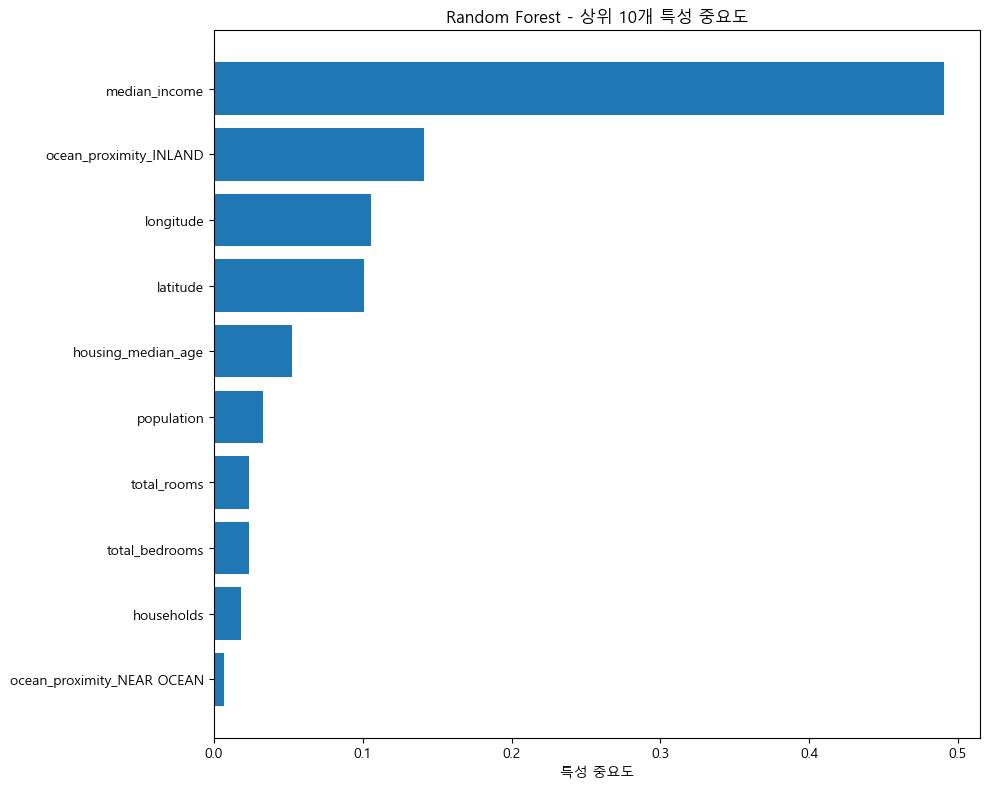

In [16]:
print("\n" + "=" * 60)
print("5단계: 특성 중요도 분석 (Random Forest)")
print("=" * 60)

# 최적화된 Random Forest에서 특성 중요도 추출
rf_model = rf_grid.best_estimator_
feature_names = num_features + list(encoder.get_feature_names_out(cat_features))

importances = rf_model.feature_importances_
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("상위 10개 중요한 특성:")
print(fi_df.head(10))

# 특성 중요도 시각화
plt.figure(figsize=(10, 8))
top_features = fi_df.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('특성 중요도')
plt.title('Random Forest - 상위 10개 특성 중요도')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
